# Vehicle Theft Analysis

## Connecting to the database

In [1]:
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session
from sqlalchemy import Column, Integer, String, Float, Boolean
from sqlalchemy.ext.automap import automap_base

import pandas as pd

In [2]:
# Local module
from mysql_connect import get_connection_string

# Create the engine
engine = create_engine(get_connection_string())
Base = automap_base()

In [3]:
# Collect all tables
inspector = inspect(engine)
inspector.get_table_names()

['locations', 'make_details', 'stolen_vehicles']

In [4]:
# Start session
session = Session(bind=engine)

# Reflect all tables in the database
Base.prepare(engine, reflect=True)
locations = Base.classes.locations
make_details  = Base.classes.make_details
stolen_vehicles  = Base.classes.stolen_vehicles

In [5]:
# Example SQL query
sql_query = '''
    SELECT * 
    FROM stolen_vehicles
'''

# Read SQL query into a DataFrame
all_data = pd.read_sql(sql_query, engine)

start_date = all_data['date_stolen'].min()
print(start_date.month, start_date.year)

end_date = all_data['date_stolen'].max()
print(end_date.month, end_date.year)

display(all_data)

10 2021
4 2022


,vehicle_id,vehicle_type,make_id,model_year,vehicle_desc,color,date_stolen,location_id
0,1,Trailer,623.0,2021.0,BST2021D,Silver,2021-11-05,102
1,2,Boat Trailer,623.0,2021.0,OUTBACK BOATS FT470,Silver,2021-12-13,105
2,3,Boat Trailer,623.0,2021.0,ASD JETSKI,Silver,2022-02-13,102
3,4,Trailer,623.0,2021.0,MSC 7X4,Silver,2021-11-13,106
4,5,Trailer,623.0,2018.0,D-MAX 8X5,Silver,2022-01-10,102
...,...,...,...,...,...,...,...,...
4548,4549,None,NaN,NaN,None,None,2022-02-18,102
4549,4550,None,NaN,NaN,None,None,2022-02-14,109
4550,4551,None,NaN,NaN,None,None,2022-03-09,102
4551,4552,None,NaN,NaN,None,None,2022-03-07,109


## Objective 1: Identify when vehicles are likely to be stolen

### Number of vehicles stolen each year

In [6]:
# SQL query
sql_query = '''
    SELECT YEAR(date_stolen) AS year, COUNT(vehicle_id) AS stolen_vehicles
    FROM stolen_vehicles
    GROUP BY year
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine)

,year,stolen_vehicles
0,2021,1668
1,2022,2885


### Number of vehicles stolen each month

In [7]:
# SQL query
sql_query = '''
    SELECT YEAR(date_stolen) AS year, MONTH(date_stolen) AS month, COUNT(vehicle_id) AS stolen_vehicles
    FROM stolen_vehicles
    GROUP BY year, month
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine).sort_values(['year', 'month'])

,year,month,stolen_vehicles
4,2021,10,464
0,2021,11,560
1,2021,12,644
3,2022,1,740
2,2022,2,763
5,2022,3,1053
6,2022,4,329


### Number of vehicles stolen each day of the week
Display the day of the week as Monday, Tuesday, etc.

In [8]:
# SQL query
sql_query = '''
    SELECT WEEKDAY(date_stolen) AS weekday, DAYNAME(date_stolen) AS day, COUNT(vehicle_id) AS stolen_vehicles
    FROM stolen_vehicles
    GROUP BY weekday, day
'''

# Read SQL query into a DataFrame
weekday_thefts = pd.read_sql(sql_query, engine).sort_values('weekday', ascending=True)
weekday_thefts

,weekday,day,stolen_vehicles
1,0,Monday,767
4,1,Tuesday,711
6,2,Wednesday,629
5,3,Thursday,619
0,4,Friday,655
3,5,Saturday,577
2,6,Sunday,595


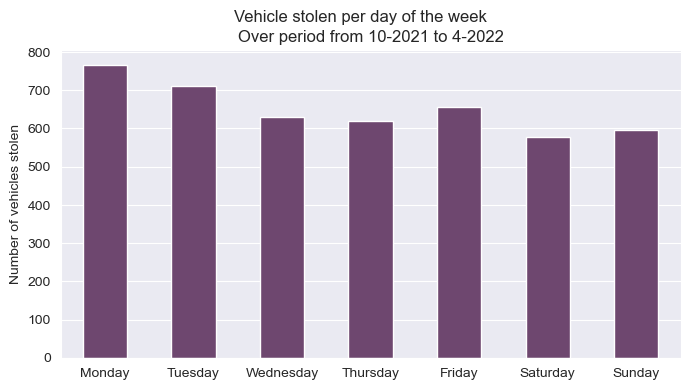

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")


fig, ax = plt.subplots(figsize=(8,4))

sns.barplot(
    data=weekday_thefts,
    x='day',
    y='stolen_vehicles',
    ax=ax,
    width=0.5,
    color='#744175'
)

fig.suptitle('Vehicle stolen per day of the week')
ax.set_title(f'Over period from {start_date.month}-{start_date.year} to {end_date.month}-{end_date.year}')

ax.set_xlabel('')
ax.set_ylabel('Number of vehicles stolen')

plt.show()

## Objective 2: Identify which vehicles are likely to be stolen

### Vehicle types that are most often and least often stolen

In [10]:
# SQL query
sql_query = '''
    SELECT vehicle_type AS most_stolen_type, COUNT(1) AS number_stolen
    FROM stolen_vehicles
    GROUP BY vehicle_type
    ORDER BY number_stolen DESC
    LIMIT 1
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine)

,most_stolen_type,number_stolen
0,Stationwagon,945


In [11]:
# SQL query
sql_query = '''
    SELECT vehicle_type AS least_stolen_type, COUNT(1) AS number_stolen
    FROM stolen_vehicles
    GROUP BY vehicle_type
    ORDER BY number_stolen ASC
    LIMIT 1
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine)

,least_stolen_type,number_stolen
0,Special Purpose Vehicle,1


In [12]:
# Total number of stolen vehicle

# SQL query
sql_query = '''
    SELECT COUNT(vehicle_id) AS total
    FROM stolen_vehicles
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine)

,total
0,4553


In [13]:
# SQL query
sql_query = '''
    SELECT
        vehicle_type,
        COUNT(1) AS number_stolen
    FROM stolen_vehicles
    GROUP BY vehicle_type
    ORDER BY number_stolen DESC
'''

# Read SQL query into a DataFrame
# Add a column with the percent of total stolen vehicle
type_stolen_df = (pd.read_sql(sql_query, engine)
                  .assign(pct_total_stolen = lambda x: 100*x['number_stolen']/x['number_stolen'].sum()))

type_stolen_df.head(10)


,vehicle_type,number_stolen,pct_total_stolen
0,Stationwagon,945,20.755546
1,Saloon,851,18.690973
2,Hatchback,644,14.144520
3,Trailer,582,12.782781
4,Utility,466,10.235010
5,Roadbike,297,6.523172
6,Moped,187,4.107182
7,Light Van,154,3.382385
8,Boat Trailer,105,2.306172
9,Trailer - Heavy,90,1.976719


### Find the average age of the cars that are stolen for each vehicle type

In [14]:
# SQL query
sql_query = '''
    
    SELECT vehicle_type, AVG(age) AS avg_age_in_year
    FROM
        (SELECT
            vehicle_type,
            model_year,
            YEAR(date_stolen) AS year,
            (YEAR(date_stolen) - model_year) AS age
        FROM stolen_vehicles) AS vehicle_ages
    GROUP BY vehicle_type
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine).round(2).sort_values('avg_age_in_year', ascending=False)

,vehicle_type,avg_age_in_year
21,Special Purpose Vehicle,64.00
18,Mobile Home - Light,34.67
16,Flat Deck Truck,27.82
5,Caravan,27.82
14,Other Truck,23.19
19,Convertible,22.67
20,Heavy Van,22.57
15,Sports Car,22.00
10,Trail Bike,20.50
11,Light Van,19.44


### Find the percent of vehicles stolen that are luxury versus standard for each vehicle type

In [15]:
# SQL query
sql_query = '''
    
    SELECT
        vehicle_type,
        COUNT(CASE WHEN make_details.make_type = 'Standard' THEN 1 END) AS standard,
        COUNT(CASE WHEN make_details.make_type = 'Luxury' THEN 1 END) AS luxury,
        COUNT(1) AS all_types
    FROM stolen_vehicles
        INNER JOIN make_details
            ON stolen_vehicles.make_id = make_details.make_id
    GROUP BY stolen_vehicles.vehicle_type
'''

# Read SQL query into a DataFrame
# Calculate percentages
(pd.read_sql(sql_query, engine)
    .assign(
        pct_standard = lambda x: round(100*x['standard']/x['all_types'],2),
        pct_luxury = lambda x: round(100*x['luxury']/x['all_types'],2)
        )
    .sort_values('pct_luxury', ascending=False)
)

,vehicle_type,standard,luxury,all_types,pct_standard,pct_luxury
19,Convertible,6,6,12,50.00,50.00
15,Sports Car,31,9,40,77.50,22.50
20,Heavy Van,6,1,7,85.71,14.29
7,Saloon,741,110,851,87.07,12.93
25,None,10,1,11,90.91,9.09
8,Stationwagon,910,35,945,96.30,3.70
6,Hatchback,623,21,644,96.74,3.26
2,Roadbike,293,4,297,98.65,1.35
11,Light Van,152,2,154,98.70,1.30
13,Utility,465,1,466,99.79,0.21


### Most common type/colour combinations
* Create a table where the rows represent the top 10 vehicle types, the columns represent the top 7 vehicle colors (plus 1 column for all other colors) and the values are the number of vehicles stolen
* Create a heat map of the table comparing the vehicle types and colors

In [16]:
type_stolen_df.head(10)

,vehicle_type,number_stolen,pct_total_stolen
0,Stationwagon,945,20.755546
1,Saloon,851,18.690973
2,Hatchback,644,14.144520
3,Trailer,582,12.782781
4,Utility,466,10.235010
5,Roadbike,297,6.523172
6,Moped,187,4.107182
7,Light Van,154,3.382385
8,Boat Trailer,105,2.306172
9,Trailer - Heavy,90,1.976719


In [17]:
# SQL query
sql_query = '''   
    SELECT
        vehicle_type, color, COUNT(1) AS stolen
    FROM stolen_vehicles
    GROUP BY vehicle_type, color
'''

# Read SQL query into a DataFrame
top_color_and_type = (pd.read_sql(sql_query, engine)
 .pivot_table(
        index='vehicle_type',
        columns='color',
        values='stolen',
        aggfunc='sum',
        margins=True)
.T.sort_values('All', ascending=False) # Transpose to sort by color (most common to least common)
.T.sort_values('All', ascending=False)[:11] # Transpose back to original pivot table, sort by most common types and keep only 10 most commons
.drop('All', axis=0).drop('All', axis=1)) # Drop margins aggregations

top_color_and_type['Other'] = top_color_and_type.iloc[:,7:].sum(axis=1) # Add a column that sums the 8th to last colour columns
top_color_and_type = top_color_and_type.drop(columns=top_color_and_type.columns[7:-1])


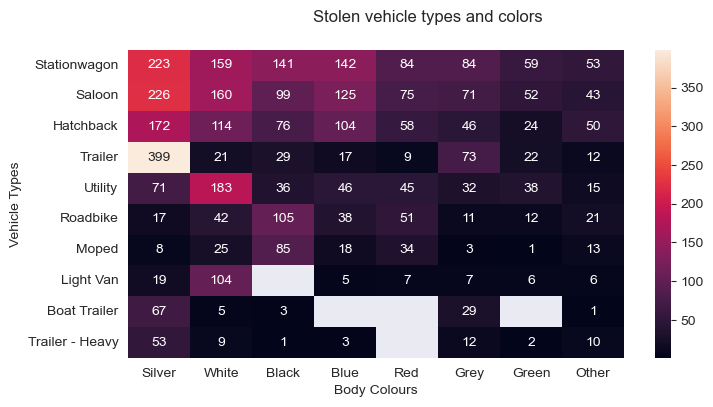

In [18]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(
    top_color_and_type,
    annot=True,
    fmt='g' # Remove scientific notation
    )

fig.suptitle('Stolen vehicle types and colors')

ax.set_xlabel('Body Colours')
ax.set_ylabel('Vehicle Types')

ax.grid(False)

plt.show()



## Objetive 3: Identify where vehicles are likely to be stolen

### Number of vehicles that were stolen in each region

In [19]:
# SQL query
sql_query = '''   
    SELECT *
    FROM stolen_vehicles
        LEFT JOIN locations
            ON locations.location_id
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine)

,vehicle_id,vehicle_type,make_id,model_year,vehicle_desc,color,date_stolen,location_id,location_id,region,country,population,density
0,1,Trailer,623.0,2021.0,BST2021D,Silver,2021-11-05,102,116,Southland,New Zealand,102400,3.28
1,1,Trailer,623.0,2021.0,BST2021D,Silver,2021-11-05,102,115,Otago,New Zealand,246000,7.89
2,1,Trailer,623.0,2021.0,BST2021D,Silver,2021-11-05,102,114,Canterbury,New Zealand,655000,14.72
3,1,Trailer,623.0,2021.0,BST2021D,Silver,2021-11-05,102,113,West Coast,New Zealand,32700,1.41
4,1,Trailer,623.0,2021.0,BST2021D,Silver,2021-11-05,102,112,Marlborough,New Zealand,51900,4.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72843,4553,None,NaN,NaN,None,None,2022-03-14,102,105,Gisborne,New Zealand,52100,6.21
72844,4553,None,NaN,NaN,None,None,2022-03-14,102,104,Bay of Plenty,New Zealand,347700,28.80
72845,4553,None,NaN,NaN,None,None,2022-03-14,102,103,Waikato,New Zealand,513800,21.50
72846,4553,None,NaN,NaN,None,None,2022-03-14,102,102,Auckland,New Zealand,1695200,343.09


In [20]:
# SQL query
sql_query = '''   
    SELECT
        stolen_vehicles.location_id AS loc_id,
        locations.region AS region,
        COUNT(1) AS stolen
    FROM stolen_vehicles
        LEFT JOIN locations
            ON stolen_vehicles.location_id = locations.location_id
    GROUP BY loc_id, region
    ORDER BY stolen DESC
'''

# Read SQL query into a DataFrame
pd.read_sql(sql_query, engine)

,loc_id,region,stolen
0,102,Auckland,1638
1,114,Canterbury,660
2,104,Bay of Plenty,446
3,109,Wellington,420
4,103,Waikato,371
5,101,Northland,234
6,105,Gisborne,176
7,115,Otago,139
8,108,Manawatū-Whanganui,139
9,107,Taranaki,112


In [21]:
# Combine the previous output with the population and density statistics for each region

# SQL query
sql_query = '''   
    SELECT
        locations.region AS region,
        locations.population AS population,
        locations.density AS density,
        COUNT(1) AS stolen
    FROM stolen_vehicles
        LEFT JOIN locations
            ON stolen_vehicles.location_id = locations.location_id
    GROUP BY region, population, density
    ORDER BY stolen DESC
'''

# Read SQL query into a DataFrame
top_regions = pd.read_sql(sql_query, engine)
top_regions.head(3)

,region,population,density,stolen
0,Auckland,1695200,343.09,1638
1,Canterbury,655000,14.72,660
2,Bay of Plenty,347700,28.80,446


### Do the types of vehicles stolen in the three most dense regions differ from the three least dense regions?

In [22]:
def get_top5_types(region):
    # SQL query
    sql_query = f'''   
        SELECT
            stolen_vehicles.vehicle_type AS type,
            COUNT(1) AS stolen
        FROM stolen_vehicles
            LEFT JOIN locations
                ON stolen_vehicles.location_id = locations.location_id
        WHERE region = '{region}'
        GROUP BY type
        ORDER BY stolen DESC
    '''

    # Read SQL query into a DataFrame, keep Top 5 types and return as a list
    return pd.read_sql(sql_query, engine).head(5)['type'].to_list()

In [23]:
top_regions_list = top_regions.head(3)['region']

types_per_region = {}

for region in top_regions_list:
    types_per_region[region] = get_top5_types(region)

stolen_types_df = pd.DataFrame(types_per_region)

stolen_types_df['National'] = type_stolen_df.head(5)['vehicle_type']
stolen_types_df

,Auckland,Canterbury,Bay of Plenty,National
0,Saloon,Stationwagon,Utility,Stationwagon
1,Stationwagon,Trailer,Saloon,Saloon
2,Hatchback,Saloon,Stationwagon,Hatchback
3,Roadbike,Hatchback,Trailer,Trailer
4,Trailer,Utility,Hatchback,Utility


### Population versus density
The size of the points is based on the number of vehicles stolen in each region

In [24]:
top_regions.sort_values('density', ascending=False)

,region,population,density,stolen
0,Auckland,1695200,343.09,1638
11,Nelson,54500,129.15,92
3,Wellington,543500,67.52,420
2,Bay of Plenty,347700,28.80,446
4,Waikato,513800,21.50,371
9,Taranaki,127300,17.55,112
5,Northland,201500,16.11,234
1,Canterbury,655000,14.72,660
10,Hawke's Bay,182700,12.92,100
8,Manawatū-Whanganui,258200,11.62,139


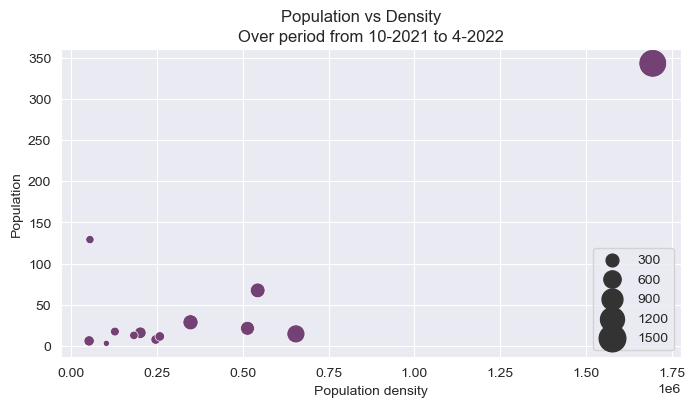

In [25]:
fig, ax = plt.subplots(figsize=(8,4))

sns.scatterplot(
    top_regions,
    x='population',
    y='density',
    size='stolen',
    sizes=(20, 400),
    c='#744175'
)

fig.suptitle('Population vs Density')
ax.set_title(f'Over period from {start_date.month}-{start_date.year} to {end_date.month}-{end_date.year}')

ax.legend(loc='lower right')

ax.set_xlabel('Population density')
ax.set_ylabel('Population')

plt.show()

# Save region file for future use (map)

In [26]:
top_regions.to_csv('../Data/top_regions.csv', index=False)

## Close session

In [27]:
# Close Session
session.close()